# Sand Hill Crane Occurrences 2023: Migration and Anomalies

## The Sandhill Crane Migration 
 The Sandhill Crane Migrates long distance every spring and fall across North America and the extreme eastern part of Asia. The typically move north to across far Northern Canada, Alaska, and Siberia to breed.  Their winter ranges are typically in the southern part of the US and in north-central Mexico. During their migrations, they gather at key stopover sites, like the Platte River in Nebraska, where over a quarter million birds gather at one time. Recent trends have shown the birds migrating later in the fall and earlier in the spring, and some populations not going as far south in winter as in the past. 

<img
src="nebraska sandhill cranes.jpg"
alt="Sandhill Cranes in Snow on the Platte River, NE" 
width="75%"
 />

There are some exceptions to this general migration.  Sandhill cranes in Mississippi, Florida, and Cuba do not migrate: they nest in the same place they inhabit year round.  Additionally, there are reports of vagrancy, or appear well outside their normal range, of sandhill cranes in Europe, China, Taiwan, and Japan. A vagrant population of sandhill cranes has also been attributed to sitting of Mothman in West Virginia in Winter 1966-67. 

<img
src="Mothman.jpg"
alt="Mothman Statue in Mount Pleasant, WV" 
width= "33%"
 />

To visualize the most recent migration cycle, data from the 2023 sandhill crane migration was plotted. 

## Data Description
Data for sandhill crane occurrences in 2023 was downloaded from the Global Biodiversity Information Facility, or GBIF.  GBIF is an international network aimed at providing open source data for all types of life on earth.  It comprised of official scientific datasets and data that is crowd sourced by citizen-scientist.  More information can be found here https://www.gbif.org/what-is-gbif

Geographical data for species distribution was download from work done by Dinerstein et al. from their paper “An Ecoregion-Based Approach to Protecting Half the Terrestrial Realm.”  This work reassessed each unique terrestrial ecoregion of the world, and determined which remaining habitat was left in each. For this plot, the shapefiles of each reassessed ecoregion were used.

## Method
To generate this plot,the data was downloaded  from the above sources.  Data was converted into geo-data frames, and merged together with a spatial join, only showing the ecoregion with occurrences, grouped by month.  The data was then normalized by region and by month.  The normalization was important to see the overall patterns of the migration, and to not put outsize emphasis on regions or months where there was overly many or overly few occurrences

## Sandhill Crane Migration, 2023 
<embed type="text/html" 
src="migration_pp.html" 
width="1400" 
height="600">

## In 2023 Migrating Sandhill Cranes continued their usual North American Migration, with a good amount of sittings in Asia and one in Europe
The plot shows a typical trend as expected from a sandhill crane migration. An exception to this is there appears to be a population in Asia, albeit small, that is mirroring the north to south migration in North America.  There also appears to have been a vagrant population in Eastern Europe in April. 

Further investigation topics could include what is happening with the population in East Asia and if there had been any recent vagrant populations in Eastern Europe before last year.

### Code 



In [1]:
# Dependancies 
import time
import zipfile
import os
import pathlib
import pandas as pd 
from getpass import getpass
from glob import glob
import geopandas as gpd

import pygbif.occurrences as occ
import pygbif.species as species

# Get month names
import calendar
import warnings

# Libraries for Dynamic mapping
import cartopy.crs as ccrs
import panel as pn
import hvplot
import hvplot.pandas
import geoviews as gv

#for getting rid of warnings for portfolio post (don't need to do untill at the end or if warning affecting plots)
#warnings.filterwarnings('ignore', category=FutureWarning)

c:\Users\Nolan Welsh\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#### Get Ecoregions

In [2]:

# Create data directory in the home folder
species_data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'migration-project-directory-Nolan-Welsh',
)
os.makedirs(species_data_dir, exist_ok=True)
species_data_dir

'C:\\Users\\Nolan Welsh\\earth-analytics\\data\\migration-project-directory-Nolan-Welsh'

In [3]:
# Set up the ecoregion boundary URL
region_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Set up a path to save the data on your machine
region_dir = os.path.join(species_data_dir, 'resolve_ecoregions')
# Make the ecoregions directory
os.makedirs(region_dir, exist_ok=True)
# Join ecoregions shapefile path
region_path = os.path.join(region_dir, 'resolve_ecoregions.shp')

# Only download once
if not os.path.exists(region_path):
    my_gdf = gpd.read_file(region_url)
    my_gdf.to_file(region_path)

<Axes: >

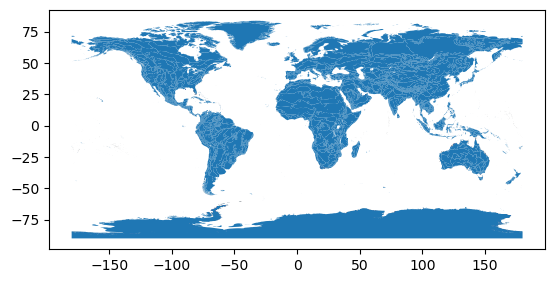

In [4]:
# Open up the ecoregions boundaries
gdf_ecoregions = gpd.read_file(region_path)

# Name the index so it will match the other data later on
gdf_ecoregions.index.name = 'ecoregion'

# Plot the ecoregions to check download
gdf_ecoregions.plot()

#### Download Species Data from GBIF

In [5]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'sandhill-crane-migration',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'sandhill-crane-migration')

In [6]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, 'GBIF username:'),
    GBIF_PWD=(getpass, 'GBIF password'),
    GBIF_EMAIL=(input, 'GBIF email'),
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

In [7]:
# Query species
species_info = species.name_lookup('Sandhill Crane', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

('Antigone canadensis', 9036008)

In [8]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF, used taxonKey instead of species key here, 
        # this worked for me base on what I saw on the GBIF website search
        gbif_query = occ.download([
            f"taxonKey = {species_key}",
            "year = 2023",
            "hasCoordinate = TRUE"
        ])
        download_key=gbif_query[0]
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]
    else:
        download_key = os.environ['GBIF_DOWNLOAD_KEY']
    # Wait for the download to build
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]

In [9]:
# Load the GBIF data
gbif_sandcrane_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    usecols=['gbifID', 'decimalLatitude','decimalLongitude', 'month', 'countryCode']
)
gbif_sandcrane_df

countryCode  decimalLatitude  decimalLongitude  month
gbifID                                                          
4704199879          US        26.649673        -81.686935      2
4826111054          US        41.437645        -80.791180      5
4668276308          US        46.991810        -95.980255      5
4670343687          CA        43.908220        -77.278465      6
4716598123          US        43.127975        -88.959660      4
...                ...              ...               ...    ...
4678731776          US        42.245117        -85.156530      3
4816316846          US        35.408360        -85.006030     12
4685501560          US        46.976685       -123.542404      1
4645021459          US        44.317410        -89.583770      5
4721553964          US        43.112324        -78.404850     10

[310591 rows x 4 columns]

In [32]:
# Filter Sandcrane occurances by country

#NA_Countries= ['US', 'CA', 'MX', 'CU', 'RU']

#gbif_filter_df =gbif_sandcrane_df[
    #gbif_sandcrane_df['countryCode'].isin(NA_Countries)
   # .drop(columns='countryCode')
   # ]
#filter out above because there is some cranes that do migrate within asia.
gbif_filter_df=gbif_sandcrane_df

In [33]:
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_filter_df, 
        geometry=gpd.points_from_xy(
            gbif_filter_df.decimalLongitude, 
            gbif_filter_df.decimalLatitude), 
        crs="EPSG:4326") #indicated we are using lat and long, in decimal degrees
    # Select the desired columns
    [['month', 'geometry']]
)
gbif_gdf

month                    geometry
gbifID                                       
4704199879      2  POINT (-81.68694 26.64967)
4826111054      5  POINT (-80.79118 41.43764)
4668276308      5  POINT (-95.98026 46.99181)
4670343687      6  POINT (-77.27846 43.90822)
4716598123      4  POINT (-88.95966 43.12798)
...           ...                         ...
4678731776      3  POINT (-85.15653 42.24512)
4816316846     12  POINT (-85.00603 35.40836)
4685501560      1  POINT (-123.5424 46.97668)
4645021459      5  POINT (-89.58377 44.31741)
4721553964     10  POINT (-78.40485 43.11232)

[310591 rows x 2 columns]

#### Normalize Data 

In [34]:
#Use a spatial Join to find all the gbif occurences containing ecoregions

gbif_ecoregion_gdf = (
    gdf_ecoregions
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['month', 'gbifID', 'SHAPE_AREA']]
     .reset_index()
     .rename(columns={
         'index':'ecoregion',
         'gbifID' : 'observation_id' #needed to reset index to get unquie IDs for every row 
     })
)
gbif_ecoregion_gdf

ecoregion  month  observation_id  SHAPE_AREA
0               4      5      4644511800    8.196573
1               4      7      4792706312    8.196573
2               4      7      4795806198    8.196573
3               4      7      4700107974    8.196573
4               4      7      4620196883    8.196573
...           ...    ...             ...         ...
301264        833      6      4729374620   35.905513
301265        833      5      4644361401   35.905513
301266        833      5      4762871013   35.905513
301267        833      5      4843448578   35.905513
301268        833      5      4763013510   35.905513

[301269 rows x 4 columns]

In [35]:
#count and group mean occurence by ecoregions and by month 
occurrence_df = (
    gbif_ecoregion_gdf
    #reset indes
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion', 'month'])
    # ...count the number of occurrences
    #.agg counts all of GBIF Ids in the group 
    .agg(
        occurrences=('observation_id', 'count'),
        area=('SHAPE_AREA', 'first'))  
)
#normalize by area 
occurrence_df['density'] = (
    occurrence_df.occurrences 
    / occurrence_df.area
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby(['ecoregion'])
    .mean()
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby(['month'])
    .mean()
)

In [36]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df['density']
    /mean_occurrences_by_ecoregion['density']
    /mean_occurrences_by_month['density']
)
occurrence_df

occurrences       area   density  norm_occurrences
ecoregion month                                                    
4         5                2   8.196573  0.244004          0.016800
          7                5   8.196573  0.610011          0.121033
9         5                3  28.388010  0.105678          0.013569
          6                2  28.388010  0.070452          0.018831
          8                8  28.388010  0.281809          0.088700
...                      ...        ...       ...               ...
833       7              167  35.905513  4.651096          0.086040
          8              176  35.905513  4.901754          0.077133
          9              131  35.905513  3.648465          0.044360
          10              94  35.905513  2.617982          0.028650
          11              25  35.905513  0.696272          0.006173

[773 rows x 4 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

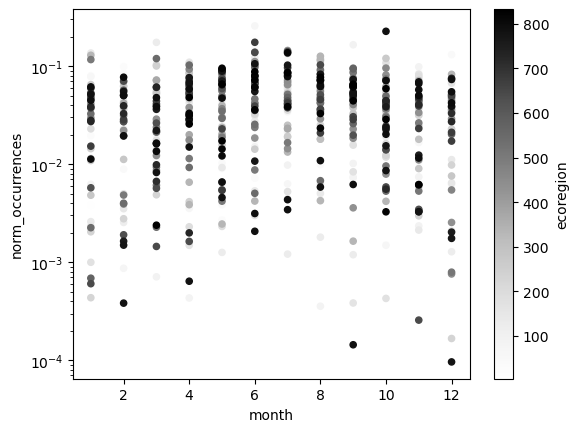

In [37]:
# plot to check distrubions 
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion',
    logy=True
)

#### Plot 

In [38]:
# Change the CRS to Mercator for mapping
gdf_ecoregions = gdf_ecoregions.to_crs(ccrs.Mercator())

# Simplify the geometry to speed up processing
gdf_ecoregions.geometry = gdf_ecoregions.simplify(
    .05, preserve_topology=False)


# Check that the plot runs in a reasonable amount of time
gdf_ecoregions.hvplot(geo=True, crs=(ccrs.Mercator()))

:Polygons   [Longitude,Latitude]

In [39]:
occurrence_df

occurrences       area   density  norm_occurrences
ecoregion month                                                    
4         5                2   8.196573  0.244004          0.016800
          7                5   8.196573  0.610011          0.121033
9         5                3  28.388010  0.105678          0.013569
          6                2  28.388010  0.070452          0.018831
          8                8  28.388010  0.281809          0.088700
...                      ...        ...       ...               ...
833       7              167  35.905513  4.651096          0.086040
          8              176  35.905513  4.901754          0.077133
          9              131  35.905513  3.648465          0.044360
          10              94  35.905513  2.617982          0.028650
          11              25  35.905513  0.696272          0.006173

[773 rows x 4 columns]

In [40]:
gdf_ecoregions

OBJECTID                                           ECO_NAME  \
ecoregion                                                                
0               1.0                                 Adelie Land tundra   
1               2.0             Admiralty Islands lowland rain forests   
2               3.0  Aegean and Western Turkey sclerophyllous and m...   
3               4.0                       Afghan Mountains semi-desert   
4               5.0                   Ahklun and Kilbuck Upland Tundra   
...             ...                                                ...   
842           848.0                      Sulawesi lowland rain forests   
843           212.0                       East African montane forests   
844           224.0                                Eastern Arc forests   
845            79.0                        Borneo montane rain forests   
846           376.0                    Kinabalu montane alpine meadows   

           BIOME_NUM                                      BIOME_NAME  \
ecoregion                                                              
0               11.0                                          Tundra   
1                1.0  Tropical & Subtropical Moist Broadleaf Forests   
2               12.0        Mediterranean Forests, Woodlands & Scrub   
3               13.0                      Deserts & Xeric Shrublands   
4               11.0                                          Tundra   
...              ...                                             ...   
842              1.0  Tropical & Subtropical Moist Broadleaf Forests   
843              1.0  Tropical & Subtropical Moist Broadleaf Forests   
844              1.0  Tropical & Subtropical Moist Broadleaf Forests   
845              1.0  Tropical & Subtropical Moist Broadleaf Forests   
846             10.0                 Montane Grasslands & Shrublands   

                 REALM ECO_BIOME_  NNH  ECO_ID  SHAPE_LENG  SHAPE_AREA  \
ecoregion                                                                
0           Antarctica       AN11    1     117    9.749780    0.038948   
1          Australasia       AU01    2     135    4.800349    0.170599   
2           Palearctic       PA12    4     785  162.523044   13.844952   
3           Palearctic       PA13    4     807   15.084037    1.355536   
4             Nearctic       NE11    1     404   22.590087    8.196573   
...                ...        ...  ...     ...         ...         ...   
842        Australasia       AU01    2     156  150.744361    9.422097   
843         Afrotropic       AF01    3       8  157.848926    5.010930   
844         Afrotropic       AF01    3       9   34.153333    0.890325   
845        Indomalayan       IN01    2     220   38.280990    9.358407   
846        Indomalayan       IN10    3     313    5.722539    0.352694   

                                    NNH_NAME    COLOR COLOR_BIO COLOR_NNH  \
ecoregion                                                                   
0                             Half Protected  #63CFAB   #9ED7C2   #257339   
1          Nature Could Reach Half Protected  #70A800   #38A700   #7BC141   
2                           Nature Imperiled  #FF7F7C   #FE0000   #EE1E23   
3                           Nature Imperiled  #FA774D   #CC6767   #EE1E23   
4                             Half Protected  #4C82B6   #9ED7C2   #257339   
...                                      ...      ...       ...       ...   
842        Nature Could Reach Half Protected  #70A800   #38A700   #7BC141   
843                     Nature Could Recover  #13ED00   #38A700   #F9A91B   
844                     Nature Could Recover  #267400   #38A700   #F9A91B   
845        Nature Could Reach Half Protected  #23DB01   #38A700   #7BC141   
846                     Nature Could Recover  #C48832   #D6C39D   #F9A91B   

             LICENSE                                           geometry  
ecoregion                                                               

In [42]:
## Make the Plot 

# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = gdf_ecoregions.join(occurrence_df[['norm_occurrences']])

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds
#set up of month widget slider
month_widget= (
pn.widgets.DiscreteSlider(
            options={
                calendar.month_abbr[month_num] :month_num
                for month_num in range(1,12)
                }
        )

)
# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        #rasterize=True,
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        #geo=True, #crs=ccrs.Mercator(), 
        tiles='CartoLight',
        title="Sandhill Crane Migration, By Month",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        frame_width=1400,
        #change widget to show months 
        widgets= {'month': month_widget},
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('migration_pp.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'ffce0ce6-6635-434b-a442-0d4dbb0aba32': {'version…